# Augmentation of image samples

Purpose of the document: To provide a interface for batch processing of image augmentations across a sample extracted from all images in the input

Augmentations performed:

<ul>
    <li> Flips: Horizontal and vertical </li>
    <li> Rotation, with size preservation - 60, 120, 180, 240, 300 degrees</li>
    <li> Gaussian Noise (Salt) - p=0.01</li>
    <li> Gaussian Blur - sigma=1.5</li>
    <li> Inversion of channels - 0.4</li>
    <li> Addition of contrast - 1.25</li>
    <li> Multiply - 1.2</li>
    <li> Sharpen images - alpha = (0,0.25)</li>
    <li> Snow dust in air - p=0.029</li>
</ul>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-required-libraries-and-images" data-toc-modified-id="Import-required-libraries-and-images-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import required libraries and images</a></span><ul class="toc-item"><li><span><a href="#Get-a-list-of-paths-for-all-images" data-toc-modified-id="Get-a-list-of-paths-for-all-images-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Get a list of paths for all images</a></span></li><li><span><a href="#Place-the-list-of-images-into-a-dataframe" data-toc-modified-id="Place-the-list-of-images-into-a-dataframe-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Place the list of images into a dataframe</a></span></li><li><span><a href="#Create-output-directories-to-store-the-augmented-images" data-toc-modified-id="Create-output-directories-to-store-the-augmented-images-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Create output directories to store the augmented images</a></span></li></ul></li><li><span><a href="#Test-a-few-augmentations" data-toc-modified-id="Test-a-few-augmentations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Test a few augmentations</a></span></li><li><span><a href="#Define-augmentation-parameters" data-toc-modified-id="Define-augmentation-parameters-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Define augmentation parameters</a></span></li><li><span><a href="#Create-combinations-of-all-acceptable-augmentations" data-toc-modified-id="Create-combinations-of-all-acceptable-augmentations-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Create combinations of all acceptable augmentations</a></span></li><li><span><a href="#Create-a-dataframe-containing-all-possible-augmentations-for-each-image,-and-sample-it" data-toc-modified-id="Create-a-dataframe-containing-all-possible-augmentations-for-each-image,-and-sample-it-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Create a dataframe containing all possible augmentations for each image, and sample it</a></span></li><li><span><a href="#Run-Augmentations" data-toc-modified-id="Run-Augmentations-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Run Augmentations</a></span><ul class="toc-item"><li><span><a href="#Create-a-list-of-all-augmentations" data-toc-modified-id="Create-a-list-of-all-augmentations-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Create a list of all augmentations</a></span></li><li><span><a href="#Create-a-function-that-will-run-the-augmentations-for-each-image" data-toc-modified-id="Create-a-function-that-will-run-the-augmentations-for-each-image-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Create a function that will run the augmentations for each image</a></span></li><li><span><a href="#Run-the-function-using-an-apply-function" data-toc-modified-id="Run-the-function-using-an-apply-function-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Run the function using an apply function</a></span></li></ul></li></ul></div>

## Import required libraries and images

In [76]:
import os
import imutils
import cv2
import imgaug as ia
from imgaug import augmenters as iaa
import pandas as pd

In [77]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [78]:
import matplotlib.pyplot as plt
%matplotlib inline


In [142]:
# PATH_INPUT_TRAIN = r'/Users/shyamravikumar/Documents/Workspace/BAI - Project/Input Files/Small/3. Train Test split/train'
PATH_INPUT_TRAIN = r'/Users/shyamravikumar/Documents/Workspace/BAI - Project/Input Files/V3/Large/3. Train Test Split/test'

# Path to resized & cleaned input images
PATH_OUTPUT = r'/Users/shyamravikumar/Documents/Workspace/BAI - Project/Input Files/V3/Large/4. Augmented images/test'

In [143]:
SEED = 120

### Get a list of paths for all images

In [144]:
def get_valid_images_in_path(path):
    """
    Return a list of valid images in a path
    
    Parameters
    ----------
        
        path: str
            Location where the images are stored
            
    Returns
    -------
        
        list of str: List of images obtained from the directory
        
    """
    from keras_preprocessing.image.utils import _iter_valid_files
    from keras_preprocessing.image.directory_iterator import DirectoryIterator
    
    list_files = list(
        _iter_valid_files(path,
                          DirectoryIterator.white_list_formats,
                          follow_links=False))
    list_files = list(map(lambda x: os.path.join(*x), list_files))
    return list_files

In [145]:
# Identify the list of available categories/classes
classes = []
for subdir in sorted(os.listdir(PATH_INPUT_TRAIN)):
    if os.path.isdir(os.path.join(PATH_INPUT_TRAIN, subdir)):
        classes.append(subdir)
classes

['defective_lav', 'defective_ldl', 'non_defective', 'non_defective_bubbles']

### Place the list of images into a dataframe

In [146]:
list_dataframes = []
for category in classes:
    path_category = os.path.join(PATH_INPUT_TRAIN, category)
    list_images = get_valid_images_in_path(path_category)
    list_dataframes.append(
        pd.DataFrame({
            'path': list_images,
            'class': np.repeat(category, len(list_images))
        })
    )

In [147]:
data_images = pd.concat(list_dataframes)
data_images['filename'] = data_images['path'].apply(os.path.basename)

In [148]:
data_images.sample(5)

,path,class,filename
1,/Users/shyamravikumar/Documents/Workspace/BAI ...,defective_lav,def_lav_4.JPG
0,/Users/shyamravikumar/Documents/Workspace/BAI ...,defective_lav,def_lav_13.JPG
3,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective,nondef_31.JPG
1,/Users/shyamravikumar/Documents/Workspace/BAI ...,defective_ldl,def_ldl_15.JPG
9,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective,nondef_52.JPG


### Create output directories to store the augmented images

In [149]:
# Ensure that the required o/p directories (for each class) exist. If not, they will be created
for feature in classes:
    folder = os.path.join(PATH_OUTPUT, feature)
    if not os.path.exists(folder):
        os.mkdir(folder)

## Test a few augmentations

In [150]:
img_input = imutils.opencv2matplotlib(cv2.imread(data_images.path.iloc[10]))

In [151]:
height=12
width=16
plt.rcParams['figure.figsize'] = (width,height)

In [152]:
# plt.imshow(img_input)

Just uncomment any one of the below, and then run the next line to view the results!

In [153]:
# augmentor = iaa.Affine(rotate=60,mode="symmetric")
# augmentor = iaa.Fliplr(1)
# augmentor = iaa.Flipud(1)
augmentor = iaa.Salt(0.01)
# augmentor = iaa.GaussianBlur(sigma=1)
# augmentor = iaa.Invert(1)
# augmentor = iaa.GammaContrast(1.25)
# augmentor = iaa.Multiply(1.2)
# augmentor = iaa.Sharpen(alpha=0.2,lightness=1) # Only sharpen
# augmentor = iaa.Add(-30) #Adjust brightness
## augmentor = iaa.AddToHueAndSaturation((-100,100)) #Adjust Hue and Saturation. Not implemented currently
# augmentor = iaa.Sequential([iaa.Flipud(1),iaa.Fliplr(1)]) #Inversion done to make snowflakes more visible

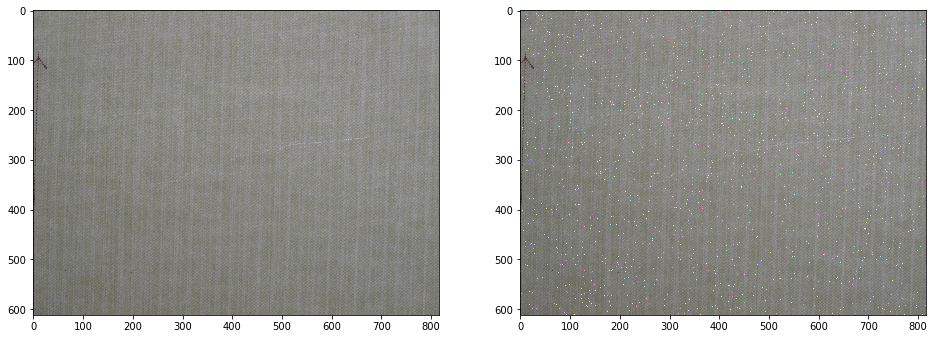

In [154]:
fig,(ax1,ax2) = plt.subplots(ncols=2)
ax1.imshow(img_input)
ax2.imshow(augmentor.augment_image(img_input))

## Define augmentation parameters

Create a dictionary of acceptable augmentations

In [155]:
acceptable_augmentations = {
    'flip_horizontal_on': iaa.Fliplr(1,name='flip_horizontal_on'),
    'flip_vertical_on': iaa.Flipud(1,name='flip_vertical_on'),
    'rotation_180': iaa.Affine(rotate=180,name='rotation_180'),
    'salt_p_0.01': iaa.Salt(0.01,name='salt_p_0.01'),
    'blur_gaussian_sigma_1': iaa.GaussianBlur(sigma=1,name='blur_gaussian_sigma_1'),
#     'invert_on': iaa.Invert(1,name='invert_on'),
    'gamma_contrast_gamma_1.25': iaa.GammaContrast(1.25,name='gamma_contrast_gamma_1.25'),
#     'multiply_mul_1.2': iaa.Multiply(1.2,name='multiply_mul_1.2'),
    'sharpen_on': iaa.Sharpen(alpha=0.2, lightness=1,name='sharpen_on'),
    'snowflakes_on': iaa.Snowflakes(0.029, speed=0.001, flake_size=(0.6, 0.8),name='snowflakes_on')
}
#Separate set of augmentations for brightness. One of these has to be used in every augmentation
# dict([('brightness_%s'%x,'iaa.Add(%s)'%x) for x in range(-60,61,10)])
#iaa.Add(0) is included so that images with original brightness are also included in the final list
acceptable_augmentations_brightness = {
#     'brightness_off': iaa.Add(0,name='brightness_off'), 
#     'brightness_-60': iaa.Add(-60,name='brightness_-60'),
#     'brightness_-50': iaa.Add(-50,name='brightness_-50'),
#     'brightness_-40': iaa.Add(-40,name='brightness_-40'),
    'brightness_-30': iaa.Add(-30,name='brightness_-30'),
#     'brightness_-20': iaa.Add(-20,name='brightness_-20'),
#     'brightness_-10': iaa.Add(-10,name='brightness_-10'),
#     'brightness_10': iaa.Add(10,name='brightness_10'),
#     'brightness_20': iaa.Add(20,name='brightness_20'),
    'brightness_30': iaa.Add(30,name='brightness_30'),
#     'brightness_40': iaa.Add(40,name='brightness_40'),
#     'brightness_50': iaa.Add(50,name='brightness_50'),
#     'brightness_60': iaa.Add(60,name='brightness_60')
}

## Create combinations of all acceptable augmentations

Logic: 
<ol>
    <li>Extract all nC1,nC2,nC3,nC4,...nCn combinations from acceptable_augmentations</li>
    <li>Take all nC2 combinations from the combination of above results with acceptable brightnesses</li>
</ol>

In [156]:
from itertools import combinations, product

In [157]:
list_augmentations = acceptable_augmentations.keys()
list_brightnesses = [(x,) for x in acceptable_augmentations_brightness.keys()]

In [158]:
# Create combinations of all augmentations excluding brightness
combinations_augmentations_phase_1 = []
for i in range(1,2):
# for i in range(1,len(list_augmentations)):
    combinations_augmentations_phase_1+= combinations(list_augmentations,i)

In [159]:
# Create combinations including brightness
combinations_augmentations_phase_2 = list(product(combinations_augmentations_phase_1,list_brightnesses))

In [160]:
print("There are %s possible combinations of augmentations for each image"%len(combinations_augmentations_phase_2))

There are 16 possible combinations of augmentations for each image


In [161]:
from itertools import chain

Get a list of all possible augmentations

In [162]:
combinations_augmentations=list(map(lambda x:tuple(chain.from_iterable(x)),combinations_augmentations_phase_2))

In [163]:
combinations_augmentations
# combinations_augmentations[500:1000:100] # Print results

[('flip_horizontal_on', 'brightness_-30'),
 ('flip_horizontal_on', 'brightness_30'),
 ('flip_vertical_on', 'brightness_-30'),
 ('flip_vertical_on', 'brightness_30'),
 ('rotation_180', 'brightness_-30'),
 ('rotation_180', 'brightness_30'),
 ('salt_p_0.01', 'brightness_-30'),
 ('salt_p_0.01', 'brightness_30'),
 ('blur_gaussian_sigma_1', 'brightness_-30'),
 ('blur_gaussian_sigma_1', 'brightness_30'),
 ('gamma_contrast_gamma_1.25', 'brightness_-30'),
 ('gamma_contrast_gamma_1.25', 'brightness_30'),
 ('sharpen_on', 'brightness_-30'),
 ('sharpen_on', 'brightness_30'),
 ('snowflakes_on', 'brightness_-30'),
 ('snowflakes_on', 'brightness_30')]

## Create a dataframe containing all possible augmentations for each image, and sample it

In [164]:
#Create a function for cross joining two datasets
def cartesian_product_simplified(left, right):
    la, lb = len(left), len(right)
    ia2, ib2 = np.broadcast_arrays(*np.ogrid[:la,:lb])

    return pd.DataFrame(
        np.column_stack([left.values[ia2.ravel()], right.values[ib2.ravel()]]))


In [165]:
data_images.shape

(26, 3)

In [166]:
res = cartesian_product_simplified(data_images,pd.DataFrame({'augmentations':combinations_augmentations}))

In [167]:
res.columns=list(data_images.columns)+['augmentations']

In [168]:
assert(res.shape[0] == data_images.shape[0] * len(combinations_augmentations))
res.shape

(416, 4)

In [169]:
res.sample(20,random_state=SEED)

,path,class,filename,augmentations
144,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective,nondef_3.JPG,"(flip_horizontal_on, brightness_-30)"
254,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective,nondef_45.JPG,"(snowflakes_on, brightness_-30)"
313,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective_bubbles,nondef_bubbles_12.JPG,"(blur_gaussian_sigma_1, brightness_30)"
34,/Users/shyamravikumar/Documents/Workspace/BAI ...,defective_lav,def_lav_8.JPG,"(flip_vertical_on, brightness_-30)"
231,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective,nondef_44.JPG,"(salt_p_0.01, brightness_30)"
83,/Users/shyamravikumar/Documents/Workspace/BAI ...,defective_ldl,def_ldl_16.JPG,"(flip_vertical_on, brightness_30)"
160,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective,nondef_31.JPG,"(flip_horizontal_on, brightness_-30)"
286,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective,nondef_9.JPG,"(snowflakes_on, brightness_-30)"
12,/Users/shyamravikumar/Documents/Workspace/BAI ...,defective_lav,def_lav_13.JPG,"(sharpen_on, brightness_-30)"
67,/Users/shyamravikumar/Documents/Workspace/BAI ...,defective_ldl,def_ldl_15.JPG,"(flip_vertical_on, brightness_30)"


In [170]:
res.to_pickle(os.path.join(PATH_OUTPUT,"list_dataset_augmentations.pickle"))
# res=pd.read_pickle(os.path.join(PATH_OUTPUT,"list_dataset_augmentations.pickle"))

In [171]:
data_sampled = res.copy()

Add a row number for each row in the dataframe, and a column to identify the augmentation

In [172]:
data_sampled.reset_index(inplace=True,drop=True)
data_sampled = data_sampled.reset_index().rename(columns={'index':'row_num'})
data_sampled['augmentation_identifier'] = 'aug_'+data_sampled['row_num'].astype('str')+'.jpg'

Add an output path for the augmented images

In [173]:
data_sampled['path_output'] = data_sampled.apply(lambda x: os.path.join(
    PATH_OUTPUT, x['class'], x['augmentation_identifier']),
                                                 axis=1)

In [174]:
print(data_sampled.shape)
data_sampled.sample(10)

(416, 7)


,row_num,path,class,filename,augmentations,augmentation_identifier,path_output
334,334,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective_bubbles,nondef_bubbles_14.JPG,"(snowflakes_on, brightness_-30)",aug_334.jpg,/Users/shyamravikumar/Documents/Workspace/BAI ...
5,5,/Users/shyamravikumar/Documents/Workspace/BAI ...,defective_lav,def_lav_13.JPG,"(rotation_180, brightness_30)",aug_5.jpg,/Users/shyamravikumar/Documents/Workspace/BAI ...
274,274,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective,nondef_9.JPG,"(flip_vertical_on, brightness_-30)",aug_274.jpg,/Users/shyamravikumar/Documents/Workspace/BAI ...
386,386,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective_bubbles,nondef_bubbles_30.JPG,"(flip_vertical_on, brightness_-30)",aug_386.jpg,/Users/shyamravikumar/Documents/Workspace/BAI ...
365,365,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective_bubbles,nondef_bubbles_25.JPG,"(sharpen_on, brightness_30)",aug_365.jpg,/Users/shyamravikumar/Documents/Workspace/BAI ...
401,401,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective_bubbles,nondef_bubbles_36.JPG,"(flip_horizontal_on, brightness_30)",aug_401.jpg,/Users/shyamravikumar/Documents/Workspace/BAI ...
218,218,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective,nondef_4.JPG,"(gamma_contrast_gamma_1.25, brightness_-30)",aug_218.jpg,/Users/shyamravikumar/Documents/Workspace/BAI ...
185,185,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective,nondef_38.JPG,"(blur_gaussian_sigma_1, brightness_30)",aug_185.jpg,/Users/shyamravikumar/Documents/Workspace/BAI ...
282,282,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective,nondef_9.JPG,"(gamma_contrast_gamma_1.25, brightness_-30)",aug_282.jpg,/Users/shyamravikumar/Documents/Workspace/BAI ...
234,234,/Users/shyamravikumar/Documents/Workspace/BAI ...,non_defective,nondef_44.JPG,"(gamma_contrast_gamma_1.25, brightness_-30)",aug_234.jpg,/Users/shyamravikumar/Documents/Workspace/BAI ...


## Run Augmentations

### Create a list of all augmentations

Sample code for reference

In [175]:

# images = np.random.randint(0, 255, (16, 128, 128, 3), dtype=np.uint8)
# seq = iaa.Sequential([iaa.Fliplr(0.5), iaa.GaussianBlur((0, 3.0))])

# # Show an image with 8*8 augmented versions of image 0 and 8*8 augmented
# # versions of image 1. Identical augmentations will be applied to
# # image 0 and 1.
# seq.show_grid([images[0], images[1]], cols=2, rows=2)

### Create a function that will run the augmentations for each image

Create a function to create hooks (i.e., only certain augmentations required by each sample will be run)

In [176]:
# Create a consolidated dictionary containing definitions for all augmentations
dict_augmentations = acceptable_augmentations_brightness.copy()
for key,val in acceptable_augmentations.items():
    dict_augmentations[key]=val


def read_image(path):
    # Read an image from a path, and return the results as an array
    # Currently, the color scheme is not changed from BGR to RGB using the following line, since we are not playing with hue anywhere
    # return imutils.opencv2matplotlib(cv2.imread(path))
    return cv2.imread(path)

def get_augmentor(augmentation_labels):
    # Create an augmentor that would perform a specific set of augmentations
    temp=[dict_augmentations[label] for label in augmentation_labels]
    return iaa.Sequential(temp).to_deterministic()

def augment_and_save_image(row,flag_return_image=False):
    augmentor = get_augmentor(row['augmentations'])
    aug_img = augmentor.augment_image(read_image(row['path']))
    
    # Store the save the augmented images
    cv2.imwrite(row['path_output'],aug_img)
    if flag_return_image:
        return aug_img

Test run the functions created

('rotation_180', 'brightness_-30')


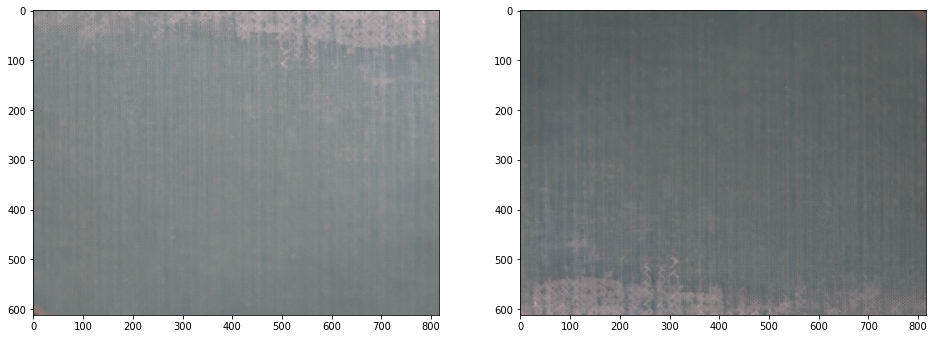

In [177]:
row = data_sampled.iloc[20]
print(row['augmentations'])

augmented_image = augment_and_save_image(row,flag_return_image=True)

fig,(ax1,ax2) = plt.subplots(ncols=2)
ax1.imshow(read_image(row['path']))
ax2.imshow(augmented_image)

# plt.imshow(augment_and_save_image(row))

### Run the function using an apply function

In [178]:
# Export the sample data & augmentations applied, so it can be retrieved later when required
data_sampled.to_csv(os.path.join(PATH_OUTPUT,"list_augmentations_applied_lda.csv"),index=False)

In [179]:
# Can simply use the apply function. I'm using tqdm to monitor progress as well
from tqdm import tqdm
tqdm.pandas()

In [180]:
data_sampled.progress_apply(augment_and_save_image,axis=1)


100%|██████████| 416/416 [00:23<00:00, 18.06it/s]

0      None
1      None
2      None
3      None
4      None
5      None
6      None
7      None
8      None
9      None
10     None
11     None
12     None
13     None
14     None
15     None
16     None
17     None
18     None
19     None
20     None
21     None
22     None
23     None
24     None
25     None
26     None
27     None
28     None
29     None
       ... 
386    None
387    None
388    None
389    None
390    None
391    None
392    None
393    None
394    None
395    None
396    None
397    None
398    None
399    None
400    None
401    None
402    None
403    None
404    None
405    None
406    None
407    None
408    None
409    None
410    None
411    None
412    None
413    None
414    None
415    None
Length: 416, dtype: object